# Beat Tracking

## Imports

In [16]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
import numpy as np

from scipy.signal import medfilt as medfilt
from scipy.ndimage import maximum_filter1d as maxfilt

from sklearn.cluster import KMeans
from collections import Counter

import mir_eval
from tqdm import tqdm

import pickle

from tqdm import tqdm_notebook

## Loading a file

First applying and demonstrating the pipeline for one file with visualization, towards the end will run/test it for a set of files for a generalized evaluation.

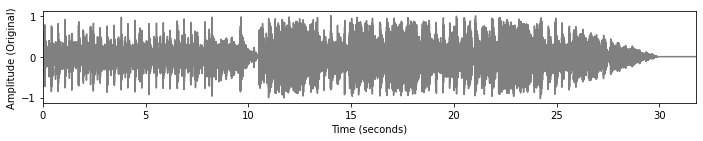

In [17]:
path_data = '../ballroom-data/'

# For now just testing with one
audio_file = path_data+'/Jive/Media-103713.wav'

# Load audio
x, sr = librosa.load(os.path.join(audio_file))
ipd.display(ipd.Audio(x,rate=sr))

# Plot audio
t1 = np.arange(x.shape[0]) / sr
plt.figure(figsize=(10, 2))
plt.plot(t1, x, color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (Original)')
plt.xlim([t1[0], t1[-1]])
plt.tight_layout()

## Onset Detection

83


[0.06, 0.4, 0.72, 1.06, 1.28, 1.72, 1.94, 2.44, 2.64, 3.12]

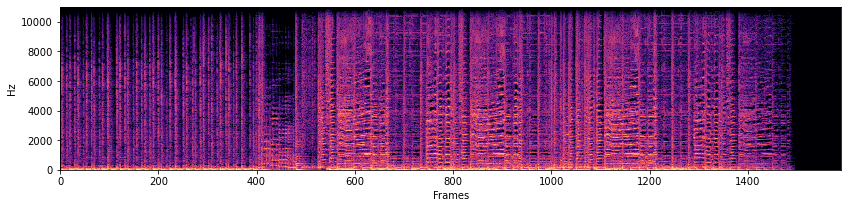

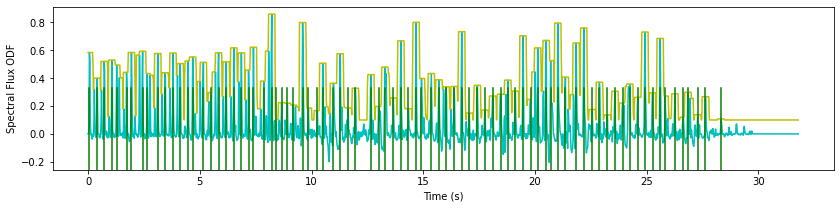

In [18]:
n = 2048
window = 'hann'
hop_length = 441
width = 15
threshold= 0.1

def detect_onsets(x, width, threshold, plot=False):
    # Short Fast Fourier Transform for spectrogram of audio
    
    D = np.abs(librosa.stft(x, window=window, hop_length=hop_length))  # STFT
    D_transp = D.transpose()
    
    # Initialise variables for iterating
    frames = len(D_transp)
    odf = np.zeros(frames)  # stores odf spectral values for insinuating onsets
    bins = len(D)
    prev_magnitude = np.zeros(bins)  # stores magnitude of previous frame
    
    # Iterate through frames, process data via spectral flux
    for i, frame in enumerate(D_transp):
        magnitude = np.abs(frame)
        
        has_greater_magnitude = np.greater(magnitude, prev_magnitude)
        diff_magnitude = np.subtract(magnitude, prev_magnitude)
        
        spectral_flux = np.mean(np.multiply(has_greater_magnitude, diff_magnitude))
        odf[i] = spectral_flux
        
        prev_magnitude = magnitude
        
    # Normalise with respect to maximum odf value
    mx = max(odf)
    if mx > 0: odf /= mx
        
    # Computing peak times by filtering and thresholding
    hop_time = hop_length / sr
    t = np.arange(len(odf)) * hop_time
    odf_med = odf - medfilt(odf, width)
    odf_max = maxfilt(odf_med, width, mode='nearest', axis=0)
    
    thresholds = [max(i, threshold) for i in odf_max]
    peak_args = np.nonzero(np.greater_equal(odf_med, thresholds))
    peak_times = peak_args[0] * hop_time
    
    if plot:
        plt.figure(figsize=(14, 3))
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='frames')
        
        
        plt.figure(figsize=(14, 3))
        plt.xlabel('Time (s)')
        plt.ylabel('Spectral Flux ODF')
        plt.plot(t, odf_med, 'c')
        plt.plot(t, thresholds, 'y')
        
        for p in peak_times:
           plt.axvline(p, ymax=0.5, color='g')
        
    
    return peak_times, odf_med
    
onsets, odf_med = detect_onsets(x, width=width, threshold=threshold, plot=True)
print(len(onsets))
list(onsets[:10])

## IOI Clustering

[0.34, 0.68, 1.36, 2.04, 2.68]

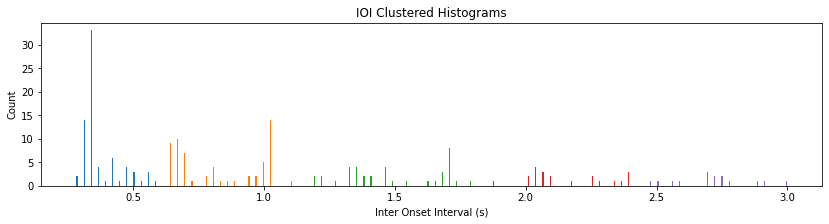

In [39]:
def ioi_clustering(onsets, n_clusters=5, limit_tempo=None, plot=False):
    
    # Compute all possible inter onset intervals
    ioi = []
    for i in range(1, len(onsets)):
        for j in range(i, len(onsets), i):
            ioi_instance = onsets[j] - onsets[j-i]

            # Limits possible iois by tempo if range is specified
            if limit_tempo:
                tempo = 60/ioi_instance
                if tempo >= limit_tempo:
                    ioi.append(ioi_instance)
            else:
                ioi.append(ioi_instance)

    temp = np.array(ioi).reshape(-1,1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(temp)
    
    # Construct clusters array and sort for convinience
    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(ioi[i])
    clusters = sorted(clusters)
    
    if plot:
        plt.figure(figsize=(14, 3))
        plt.title('IOI Clustered Histograms')
        plt.xlabel('Inter Onset Interval (s)')
        plt.ylabel('Count')
        plt.hist(clusters, 100)  
    
    # Find the mode of each cluster
    ioi_common = []
    for clust in clusters:
        dict_counter = Counter()
        for x  in clust:
            dict_counter[round(x, 4)] += 1
    
        ioi_common.append(dict_counter.most_common()[0][0])
        
    return ioi_common
    
ioi_common = ioi_clustering(onsets, n_clusters= 5, limit_tempo=20, plot=True)  # have the option to limit tempo
ioi_common

## Agent Voting

In [20]:
class Agent:
  def __init__(self, direction, ioi, start):
    self.direction = direction 
    self.ioi = ioi
    self.start = start
    self.predictions = []  # beat predictions
    self.error = []  # error of beats from closest onset
    
# Agent hypothesises beat path from start to finish
def agent_forward_pass(ioi, i, onsets, max_time):
    a = Agent( 'forward', ioi, onsets[i])
            
    state = a.start    
    while state < max_time:

        # Compute error from state to closest onset
        distances = np.array([abs(state - x) for x in onsets])
        error = min(distances)
        
        a.error.append(error)
        a.predictions.append(state)
        
        # jump by the hypothesised ioi
        state += ioi
        
    return a

# Agent hypothesises beat path from end to beginning
def agent_backward_pass(ioi, i, onsets):
    a = Agent('backward', ioi, onsets[-i])
            
    state = a.start    
    while state > 0:

        # Compute error from state to closest onset
        distances = np.array([abs(state - x) for x in onsets])
        error = min(distances)
        
        a.error.append(error)
        a.predictions.append(state)
        
        # jump backwards by the hypothesised ioi
        state -= ioi
        
    return a
    

# Multiple agents hypothesise beat paths, to later be evaluated
def agent_voting(max_time, onsets, ioi_common, bidirectional=True):
    
    # Number of agents proportionate to number of clusters common ioi and starting onsets
    # Loops through common iois, and all possible start points
    agents = []
    for ioi in ioi_common:
        for i in range(len(onsets)//2): # takes first/last half of onsets as potential starts 
            
            # Create, execute and store new agents
            agents.append(agent_forward_pass(ioi, i, onsets, max_time))
            if bidirectional: agents.append(agent_backward_pass(ioi, i, onsets))
                
    return agents

max_time = (len(x) / sr)
print(max_time)  # this is the max time of the audio
agents = agent_voting(max_time, onsets, ioi_common)  # have the option to test both directions
print(len(agents), 'agents have voted in this song\'s election.')

31.787936507936507
410 agents have voted in this song's election.


Its interesting to note that larger iois overall have less onset errors. Since the larger the ioi, the more indicative it is of a downbeat.

In [21]:
# Counts all the votes and processes accordingly for results
def best_agent(agents):
    beat_scores = Counter()
    
    # Compute scores per beat based on popularity and onset error
    # disencourages error (added +0.001 in case its zero)
    for a in agents:
        for i, p in enumerate(a.predictions):
            beat_scores[round(p, 3)] += 1 / (a.error[i] + 0.001)
        
    # Compute agent score based on final beat event scores
    agent_scores = []
    for a in agents:
        agent_score = 0
        
        for i, p in enumerate(a.predictions):
            agent_score += beat_scores[round(p, 3)]
            
        agent_scores.append(agent_score)
        
    best_agent = agents[np.argmax(agent_scores)]  
    
    return sorted(best_agent.predictions)
    
estimated_beats = best_agent(agents)
print(np.array(estimated_beats))

[ 0.06  0.4   0.74  1.08  1.42  1.76  2.1   2.44  2.78  3.12  3.46  3.8
  4.14  4.48  4.82  5.16  5.5   5.84  6.18  6.52  6.86  7.2   7.54  7.88
  8.22  8.56  8.9   9.24  9.58  9.92 10.26 10.6  10.94 11.28 11.62 11.96
 12.3  12.64 12.98 13.32 13.66 14.   14.34 14.68 15.02 15.36 15.7  16.04
 16.38 16.72 17.06 17.4  17.74 18.08 18.42 18.76 19.1  19.44 19.78 20.12
 20.46 20.8  21.14 21.48 21.82 22.16 22.5  22.84 23.18 23.52 23.86 24.2
 24.54 24.88 25.22 25.56 25.9  26.24 26.58 26.92 27.26 27.6  27.94 28.28
 28.62 28.96 29.3  29.64 29.98 30.32 30.66 31.   31.34 31.68]


## Post Processing

In [22]:
# Removes the last n beats if they fall on silence
def filter_end_beats(estimated_beats, odf_med, n):
    
    clean_beats = estimated_beats[:-n]
    sf_prev = 0
    for b in estimated_beats[-n:]:
        sf = odf_med[int((b * sr) / hop_length)]
        if sf != 0:
            clean_beats.append(b)
            
    return clean_beats  
    
estimated_beats = filter_end_beats(estimated_beats, odf_med, 10)
np.array(estimated_beats)

array([ 0.06,  0.4 ,  0.74,  1.08,  1.42,  1.76,  2.1 ,  2.44,  2.78,
        3.12,  3.46,  3.8 ,  4.14,  4.48,  4.82,  5.16,  5.5 ,  5.84,
        6.18,  6.52,  6.86,  7.2 ,  7.54,  7.88,  8.22,  8.56,  8.9 ,
        9.24,  9.58,  9.92, 10.26, 10.6 , 10.94, 11.28, 11.62, 11.96,
       12.3 , 12.64, 12.98, 13.32, 13.66, 14.  , 14.34, 14.68, 15.02,
       15.36, 15.7 , 16.04, 16.38, 16.72, 17.06, 17.4 , 17.74, 18.08,
       18.42, 18.76, 19.1 , 19.44, 19.78, 20.12, 20.46, 20.8 , 21.14,
       21.48, 21.82, 22.16, 22.5 , 22.84, 23.18, 23.52, 23.86, 24.2 ,
       24.54, 24.88, 25.22, 25.56, 25.9 , 26.24, 26.58, 26.92, 27.26,
       27.6 , 27.94, 28.28, 28.62, 28.96, 29.3 , 29.64])

## Results

OrderedDict([('F-measure', 1.0),
             ('Cemgil', 0.8153203110880012),
             ('Cemgil Best Metric Level', 0.8153203110880012),
             ('Goto', 1.0),
             ('P-score', 1.0),
             ('Correct Metric Level Continuous', 0.9726027397260274),
             ('Correct Metric Level Total', 0.9863013698630136),
             ('Any Metric Level Continuous', 0.9726027397260274),
             ('Any Metric Level Total', 0.9863013698630136),
             ('Information gain', 0.4522030354285873)])

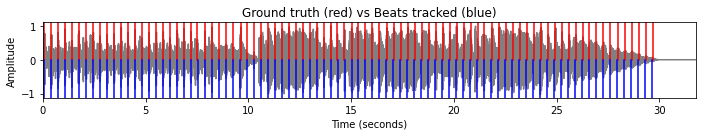

In [23]:
path_data = '../ballroom-annotations/'

# For now just testing with one
annotations_file = path_data+'Media-103713.beats'

def plot_play(true_beats, estimated_beats, x):
    # Audio player
    y = librosa.clicks(times=estimated_beats, sr=sr, length=len(x))
    ipd.display(ipd.Audio(x + y, rate=sr))

    # Plot audio
    t1 = np.arange(x.shape[0]) / sr
    plt.figure(figsize=(10, 2))
    plt.plot(t1, x, color='gray')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim([t1[0], t1[-1]])
    plt.title('Ground truth (red) vs Beats tracked (blue)')
    plt.tight_layout()

    for b in true_beats:
       plt.axvline(b, ymin=0.5, color='r')
    for b in estimated_beats:
       plt.axvline(b, ymax=0.5, color='b')  

    
beat_annotations = np.genfromtxt(annotations_file, delimiter=' ')
true_beats = beat_annotations.transpose()[0]
plot_play(true_beats, estimated_beats, x)
mir_eval.beat.evaluate(true_beats, np.array(estimated_beats))

## Main method

In [24]:
def beatTracker(audiopath):
    # Loading file
    x, sr = librosa.load(os.path.join(audiopath))
    
    # Onsets and IOI Clustering
    onsets, odf_med = detect_onsets(x, width, threshold_onsets)
    ioi_common = ioi_clustering(onsets, n_clusters, limit_tempo) 
    
    # Agent beat voting
    max_time = len(x) / sr
    agents = agent_voting(max_time, onsets, ioi_common, bidirectional)
    estimated_beats = best_agent(agents)
    
    # Post filter
    if n_last_beats:
        estimated_beats = filter_end_beats(estimated_beats, odf_med, n_last_beats)
        
    return estimated_beats

Example hyper params and call

In [25]:
# Hyperparameters example
audiopath = '../ballroom-data/Jive/Media-103713.wav'
threshold_onsets = 0.1
n_clusters = 5
limit_tempo = 20
n_last_beats = 10
bidirectional = True

# method call
estimated_beats = beatTracker(audiopath)
np.array(estimated_beats)

array([ 0.06,  0.4 ,  0.74,  1.08,  1.42,  1.76,  2.1 ,  2.44,  2.78,
        3.12,  3.46,  3.8 ,  4.14,  4.48,  4.82,  5.16,  5.5 ,  5.84,
        6.18,  6.52,  6.86,  7.2 ,  7.54,  7.88,  8.22,  8.56,  8.9 ,
        9.24,  9.58,  9.92, 10.26, 10.6 , 10.94, 11.28, 11.62, 11.96,
       12.3 , 12.64, 12.98, 13.32, 13.66, 14.  , 14.34, 14.68, 15.02,
       15.36, 15.7 , 16.04, 16.38, 16.72, 17.06, 17.4 , 17.74, 18.08,
       18.42, 18.76, 19.1 , 19.44, 19.78, 20.12, 20.46, 20.8 , 21.14,
       21.48, 21.82, 22.16, 22.5 , 22.84, 23.18, 23.52, 23.86, 24.2 ,
       24.54, 24.88, 25.22, 25.56, 25.9 , 26.24, 26.58, 26.92, 27.26,
       27.6 , 27.94, 28.28, 28.62, 28.96, 29.3 , 29.64])

# Evaluation

Note that from this point onwards, scripts are just used to evaluate the model. None of the following code is part of the proposed implementation, but just done for plots and comparisons for evaluating on a larger scale.

## Initial evaluation (approx 20 mins)

In [ ]:
data_path = '../ballroom-data'
annotations_path = '../ballroom-annotations'

limit_tempo = 20  
n_last_beats = 10  
threshold_onsets = 0.1

# Will investigate in grid search
n_clusters = 5
bidirectional = True

# Specify genre directories to consider
genres = ['ChaChaCha', 'Jive', 'Quickstep', 'Rumba-American', 'Rumba-International', 
          'Rumba-Misc', 'Samba', 'Tango', 'VienneseWaltz', 'Waltz']
p_scores = [[] for _ in genres]

# Just for keeping track of progress (698 files in total)
pbar = tqdm(total=698)

# Loop through each genre
for i, g in enumerate(genres):
    genre_path = data_path + '/' + g + '/'
    
    for entry in os.scandir(genre_path):
        if entry.name[-4:] == '.wav':
            estimated_beats = beatTracker(entry)
            
            # Loading annotations to test
            name = entry.name.split('/')[-1].split('.')[0]
            annotation_file = annotations_path + '/' + name + '.beats'
            beat_annotation = np.genfromtxt(annotations_file, delimiter=' ')
            true_beats = beat_annotation.transpose()[0]
            
            ps = mir_eval.beat.p_score(true_beats, np.array(estimated_beats))
            p_scores[i].append(ps)
            
            pbar.update(1)
pbar.close()

In [ ]:
# Just to back up this one here's results
with open('../results/p_scores_init2.pickle', 'wb') as fp:
    pickle.dump(p_scores1, fp)

In [71]:
# Compute average per genre as well as show min and max p_score
for i, g in enumerate(genres):
    print(g, round(sum(p_scores1[i])/len(p_scores1[i]), 2), round(min(p_scores1[i]),2), round(max(p_scores1[i]),2))

ChaChaCha 0.37 0.0 0.47
Jive 0.31 0.0 1.0
Quickstep 0.39 0.0 0.47
Rumba-American 0.37 0.25 0.47
Rumba-International 0.26 0.0 0.45
Rumba-Misc 0.34 0.07 0.46
Samba 0.33 0.0 0.76
Tango 0.32 0.05 0.48
VienneseWaltz 0.35 0.0 0.99
Waltz 0.35 0.0 0.98


Text(0.5, 0, 'P Scores of Estimated Beats per Genre')

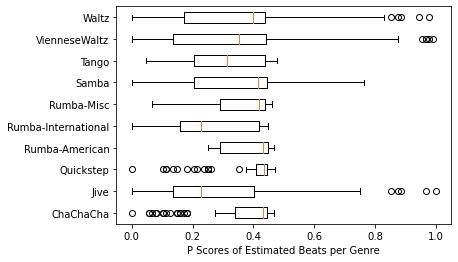

In [72]:
plt.figure()
plt.boxplot(p_scores1, labels=genres, vert=False)
plt.xlabel('P Scores of Estimated Beats per Genre')  # b=True, t=0.1, n=5

## Visually Comparing different beat score approaches

In [ ]:
genres = ['ChaChaCha', 'Jive', 'Quickstep', 'Rumba-American', 'Rumba-International', 
          'Rumba-Misc', 'Samba', 'Tango', 'VienneseWaltz', 'Waltz']

# With ioi
with open('../results/p_scores_init.pickle', 'rb') as handle:
    p_scores0 = pickle.load(handle)

# Simple   
with open('../results/p_scores_init1.pickle', 'rb') as handle:
    p_scores1 = pickle.load(handle)
    
# With saliency    
with open('../results/p_scores_init2.pickle', 'rb') as handle:
    p_scores2 = pickle.load(handle)

# Calculating average p scores for each
flat_list0 = [item for sublist in p_scores0 for item in sublist]
flat_list1 = [item for sublist in p_scores1 for item in sublist]
flat_list2 = [item for sublist in p_scores2 for item in sublist]
avg0 = str(round(sum(flat_list0) / len(flat_list0),3))
avg1 = str(round(sum(flat_list1) / len(flat_list1),3))
avg2 = str(round(sum(flat_list2) / len(flat_list2),3))

# beat_scores[round(p, 3)] += a.ioi / (a.error[i] + 0.001)
plt.figure()
plt.boxplot(p_scores0, labels=genres, vert=False) # b=True, t=0.1, n=5
plt.ylabel('IOI Consideration \n (' + avg0 + ' Average)')

# beat_scores[round(p, 3)] += 1 / (a.error[i] + 0.001)
plt.figure()
plt.boxplot(p_scores1, labels=genres, vert=False) # b=True, t=0.1, n=5
plt.ylabel('Simple \n (' + avg1 + ' Average)')

# beat_scores[round(p, 3)] += odf[int((b * sr) / hop_length)] / (a.error[i] + 0.001)
plt.figure()
plt.boxplot(p_scores2, labels=genres, vert=False)
plt.xlabel('P Scores of Estimated Beats per Genre')  # b=True, t=0.1, n=5
plt.ylabel('Saliency Consideration \n (' + avg2 + ' Average)')

## Grid Search Evaluation (approx 3 hours)

In [89]:
# 8 combinations to test
biderectional_grid = [True, False]
n_clusters_grid = [5, 9, 11, 15]


data_path = '../ballroom-data'
annotations_path = '../ballroom-annotations'

limit_tempo = 20 
n_last_beats = 10  
threshold_onsets = 0.1

genres = ['ChaChaCha', 'Jive', 'Quickstep', 'Rumba-American', 'Rumba-International', 
          'Rumba-Misc', 'Samba', 'Tango', 'VienneseWaltz', 'Waltz']
grid = np.zeros((8, len(genres)))  # set as a grid of params + results
param_info = []  # corresponding param info to grid

pbar = tqdm_notebook(total=698 * 8)

x = 0
for bidirectional in biderectional_grid:
    for n_clusters in n_clusters_grid:

        param_info.append([bidirectional, threshold_onsets, n_clusters])
        p_scores = []

        # Loop through each genre
        for i, g in enumerate(genres):
            genre_path = data_path + '/' + g + '/'

            total_songs = sum(len(files) for _, _, files in os.walk(genre_path))
            p_score = 0

            for entry in os.scandir(genre_path):
                estimated_beats = beatTracker(entry)

                # Loading annotations to test
                name = entry.name.split('/')[-1].split('.')[0]
                annotation_file = annotations_path + '/' + name + '.beats'
                beat_annotation = np.genfromtxt(annotations_file, delimiter=' ')
                true_beats = beat_annotation.transpose()[0]

                ps = mir_eval.beat.p_score(true_beats, np.array(estimated_beats))
                p_score += ps / total_songs

                pbar.update(1)

            p_scores.append(p_score)

        grid[x] = np.array(p_scores)
        x += 1
                
pbar.close()

# Just to back up this one here's results
with open('../results/grid.pickle', 'wb') as fp:
    pickle.dump(grid, fp)
    
with open('../results/param_info.pickle', 'wb') as fp:
    pickle.dump(param_info, fp)    

<ipython-input-89-fc25d66bcd4a>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(total=698 * 8)


In [90]:
# Showing average grid results
for i, g in enumerate(grid):
    print(param_info[i], np.sum(grid[i])/len(grid[i]))

[True, 0.1, 5] 0.33886323476800567
[True, 0.1, 9] 0.3422893726725382
[True, 0.1, 11] 0.35417990292468937
[True, 0.1, 15] 0.3602237151115608
[False, 0.1, 5] 0.33075433874991367
[False, 0.1, 9] 0.34334737486674005
[False, 0.1, 11] 0.35234158233846674
[False, 0.1, 15] 0.36726108583247735


## Same as initial Evaluation, but with params best from grid search (approx 20 mins)

Running best model from grid search again to have all p score datapoints. Didnt do this beforehand as to not overload my RAM with thousands of p score data points during the grid search

In [26]:
data_path = '../ballroom-data'
annotations_path = '../ballroom-annotations'

limit_tempo = 20  
n_last_beats = 10  
threshold_onsets = 0.1

# Will investigate in grid search
n_clusters = 15
bidirectional = False

# Specify genre directories to consider
genres = ['ChaChaCha', 'Jive', 'Quickstep', 'Rumba-American', 'Rumba-International', 
          'Rumba-Misc', 'Samba', 'Tango', 'VienneseWaltz', 'Waltz']
p_scores_mine = [[] for _ in genres]

# Just for keeping track of progress (698 files in total)
pbar = tqdm_notebook(total=698)

# Loop through each genre
for i, g in enumerate(genres):
    genre_path = data_path + '/' + g + '/'
    
    for entry in os.scandir(genre_path):
        if entry.name[-4:] == '.wav':
            estimated_beats = beatTracker(entry)
            
            # Loading annotations to test
            name = entry.name.split('/')[-1].split('.')[0]
            annotation_file = annotations_path + '/' + name + '.beats'
            beat_annotation = np.genfromtxt(annotations_file, delimiter=' ')
            true_beats = beat_annotation.transpose()[0]
            
            ps = mir_eval.beat.p_score(true_beats, np.array(estimated_beats))
            p_scores_mine[i].append(ps)
            
            pbar.update(1)
pbar.close()

<ipython-input-26-d6a593fc6165>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(total=698)


  0%|          | 0/698 [00:00<?, ?it/s]

In [ ]:
# Just to back up this one here's results
with open('../results/p_scores_mine.pickle', 'wb') as fp:
    pickle.dump(p_scores_mine, fp)

## Comparison

Evaluate another implemented beat tracker against my best beat tracker

In [92]:
# Loading my best model's p scores
with open('../results/p_scores_mine.pickle', 'rb') as handle:
    p_scores_mine = pickle.load(handle)

In [ ]:
# Executing and evaluating Dynamic Programming System

from tqdm import tqdm_notebook

# Specify genre directories to consider
genres = ['ChaChaCha', 'Jive', 'Quickstep', 'Rumba-American', 'Rumba-International', 
          'Rumba-Misc', 'Samba', 'Tango', 'VienneseWaltz', 'Waltz']
p_scores_theirs = [[] for _ in genres]

# Just for keeping track of progress (698 files in total)
pbar = tqdm_notebook(total=698)

# Loop through each genre
for i, g in enumerate(genres):
    genre_path = data_path + '/' + g + '/'
    
    for entry in os.scandir(genre_path):
        if entry.name[-4:] == '.wav':
            y, sr = librosa.load(os.path.join(entry))
            _, estimated_beats = librosa.beat.beat_track(y=y, sr=sr)
            estimated_beats = librosa.frames_to_time(estimated_beats, sr=sr)
            
            # Loading annotations to test
            name = entry.name.split('/')[-1].split('.')[0]
            annotation_file = annotations_path + '/' + name + '.beats'
            beat_annotation = np.genfromtxt(annotations_file, delimiter=' ')
            true_beats = beat_annotation.transpose()[0]
            
            ps = mir_eval.beat.p_score(true_beats, np.array(estimated_beats))
            p_scores_theirs[i].append(ps)
            
            pbar.update(1)
pbar.close()

# Just to back up this one here's results
with open('../results/p_scores_theirs.pickle', 'wb') as fp:
    pickle.dump(p_scores_theirs, fp)

In [28]:
# Loading up
with open('../results/p_scores_theirs.pickle', 'rb') as fp:
    p_scores_theirs = pickle.load(fp)

Text(0, 0.5, 'Dynamic Programming \n (0.289 Average)')

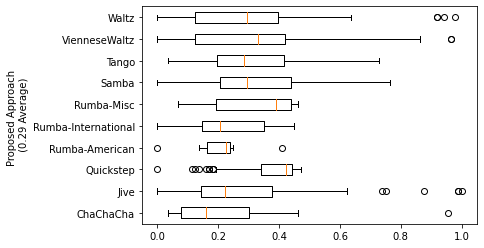

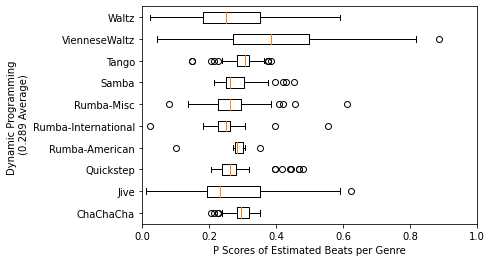

In [29]:
# Boxplots and averages of both

# Calculating average p scores for each
flat_list0 = [item for sublist in p_scores_mine for item in sublist]
flat_list1 = [item for sublist in p_scores_theirs for item in sublist]
avg0 = str(round(sum(flat_list0) / len(flat_list0),3))
avg1 = str(round(sum(flat_list1) / len(flat_list1),3))

plt.figure()
plt.boxplot(p_scores_mine, labels=genres, vert=False)
plt.ylabel('Proposed Approach \n (' + avg0 + ' Average)')

plt.figure()
plt.boxplot(p_scores_theirs, labels=genres, vert=False)
plt.xlabel('P Scores of Estimated Beats per Genre') 
plt.xlim([0,1])
plt.ylabel('Dynamic Programming \n (' + avg1 + ' Average)')

In [97]:
# Compute average per genre as well as show min and max p_score
for i, g in enumerate(genres):
    print(g, round(sum(p_scores_mine[i])/len(p_scores_mine[i]), 2), round(min(p_scores_mine[i]),2), round(max(p_scores_mine[i]),2))

ChaChaCha 0.39 0.07 0.95
Jive 0.34 0.0 1.0
Quickstep 0.41 0.11 0.45
Rumba-American 0.32 0.19 0.49
Rumba-International 0.3 0.0 0.46
Rumba-Misc 0.37 0.07 0.46
Samba 0.38 0.0 0.76
Tango 0.39 0.08 0.73
VienneseWaltz 0.4 0.0 0.97
Waltz 0.37 0.0 0.47


In [98]:
# Compute average per genre as well as show min and max p_score
for i, g in enumerate(genres):
    print(g, round(sum(p_scores_theirs[i])/len(p_scores_theirs[i]), 2), round(min(p_scores_theirs[i]),2), round(max(p_scores_theirs[i]),2))

ChaChaCha 0.3 0.2 0.35
Jive 0.26 0.01 0.62
Quickstep 0.28 0.2 0.48
Rumba-American 0.27 0.1 0.35
Rumba-International 0.25 0.02 0.56
Rumba-Misc 0.28 0.08 0.61
Samba 0.28 0.22 0.45
Tango 0.3 0.15 0.39
VienneseWaltz 0.39 0.05 0.89
Waltz 0.27 0.02 0.59
